In [1]:
#VAA 중도형 

from base_functions import *

start, end =  "2020-01-10", "2022-10-10"
riskTickers = {
    "snp":"^GSPC", #미국 대형주
    "nasdaq":"QQQ",
    "iwm":"IWM", #미국 소형주
    "vgk":"VGK", #유럽 주식
    "ewj":"EWJ", #일본 주식
    "eem":"EEM", #개발도상국 주식
    "vnq":"VNQ", #부동산
    "GLD":"GLD", #금 
    "dbc":"DBC", #원자재
    "hyg":"HYG", #하이랜드 채권
    "lqd":"LQD", #미국 회사채 
    "tlt":"TLT", #미국 장기체   
}

safeTickers = {
    "lqd": "LQD", #미국 회사채
    "ief": "IEF", #미국 중기국채
    "shy": "SHY", #미국 단기국채 
}
riskCloseData = getCloseDataAll(riskTickers, start, end)
safeCloseData = getCloseDataAll(safeTickers, start, end)
print(f"risk:\n{riskCloseData}\nsafe:\n{safeCloseData}")

risk:
                    snp      nasdaq         iwm        vgk        ewj  \
Date                                                                    
2020-01-09  3274.699951  218.990005  165.509995  58.490002  59.939999   
2020-01-10  3265.350098  218.429993  164.889999  58.209999  59.520000   
2020-01-13  3288.129883  220.949997  165.960007  58.500000  59.860001   
2020-01-14  3283.149902  220.080002  166.570007  58.540001  59.880001   
2020-01-15  3289.290039  220.169998  167.369995  58.560001  59.660000   
...                 ...         ...         ...        ...        ...   
2022-10-04  3790.929932  282.130005  176.000000  49.389999  51.320000   
2022-10-05  3783.280029  281.980011  174.699997  48.619999  50.779999   
2022-10-06  3744.520020  279.760010  173.720001  47.560001  50.320000   
2022-10-07  3639.659912  269.100006  168.610001  46.669998  49.810001   
2022-10-10  3612.389893  266.410004  167.669998  46.470001  49.610001   

                  eem        vnq         GLD

In [20]:
pd.set_option("display.max_rows", 10)
def getMomentumScore(rebalDate):
    momentumScore = rebalDate.copy()
    for month, weight in [[12, 1], [4, 3], [2, 6], [1, 12]]:
        momentumScore += (rebalDate - rebalDate.shift(month).fillna(method="bfill")) * weight
    
    return momentumScore


In [38]:
def getRiskWeights(closeDataSet):
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터

    momentumScore = getMomentumScore(priceOnRebalDate)
    
    status = pd.DataFrame([], index=momentumScore.index)
    for asset, assetMomentumScore in momentumScore.iteritems():
        status[asset] = np.where(assetMomentumScore < 0, 1, 0)
    status.iloc[0] = 0

    getPercentage = lambda count : (4 - count) / 4
    status["falling"] =  status.apply(np.sum, axis=1)
    status["risk percentage"] = np.where(status["falling"] < 4, getPercentage(status["falling"]), 0)
    print(status)

    weights = pd.DataFrame([], index=priceOnRebalDate.index, columns=priceOnRebalDate.columns)
    for row in momentumScore.iloc:
        target = row.sort_values(ascending=False)[0:5]
        for name, item in target.iteritems():
            total = status.loc[row.name]["risk percentage"]
            weights.loc[row.name][name] = total / 5

    weights.fillna(0, inplace=True)
    print(weights)

    return weights, status["risk percentage"]


riskWeights, riskPercentage = getRiskWeights(riskCloseData)

            snp  nasdaq  iwm  vgk  ewj  eem  vnq  GLD  dbc  hyg  lqd  tlt  \
Date                                                                        
2020-01-31    0       0    0    0    0    0    0    0    0    0    0    0   
2020-02-28    1       1    1    1    1    0    1    0    1    0    0    0   
2020-03-31    1       1    1    1    1    1    1    0    1    1    1    0   
2020-04-30    0       0    0    1    0    0    0    0    1    0    0    0   
2020-05-29    0       0    0    0    0    0    0    0    0    0    0    0   
...         ...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-06-30    1       1    1    1    1    1    1    0    0    1    1    1   
2022-07-29    0       0    0    0    0    1    0    0    0    0    0    0   
2022-08-31    0       0    0    1    0    0    1    1    0    0    0    1   
2022-09-30    1       1    1    1    1    1    1    1    1    1    1    1   
2022-10-10    0       1    0    1    0    1    1    0    0    0    1    1   

In [44]:
def getSafeWeights(closeDataSet, riskPercentage):
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    momentumScore = getMomentumScore(priceOnRebalDate)
    print(momentumScore)
    
    weights = pd.DataFrame([], index=priceOnRebalDate.index, columns=priceOnRebalDate.columns)
    max_values = momentumScore.idxmax(axis=1)

    for idx, asset in max_values.iteritems():
        weights.loc[idx][asset] = 1 - riskPercentage.loc[idx]
    weights.fillna(0, inplace=True)

    return weights

safeWeights = getSafeWeights(safeCloseData, riskPercentage)
print(safeWeights)

                   lqd         ief         shy
Date                                          
2020-01-31  131.089996  114.040001   85.120003
2020-02-28  156.159912  188.100029   99.150017
2020-03-31  -56.329826  246.520042  113.449890
2020-04-30  171.349991  180.929901  101.500061
2020-05-29  221.000122  159.540054   91.080048
...                ...         ...         ...
2022-06-30  -26.950058   44.350082   66.730034
2022-07-29  130.200012  131.269920   80.230072
2022-08-31    4.609924   20.180069   64.379974
2022-09-30 -118.900040  -59.710068   45.849953
2022-10-10  -14.089935   -1.869911   60.520004

[34 rows x 3 columns]
            lqd   ief  shy
Date                      
2020-01-31  0.0  0.00  0.0
2020-02-28  0.0  1.00  0.0
2020-03-31  0.0  1.00  0.0
2020-04-30  0.0  0.50  0.0
2020-05-29  0.0  0.00  0.0
...         ...   ...  ...
2022-06-30  0.0  0.00  1.0
2022-07-29  0.0  0.25  0.0
2022-08-31  0.0  0.00  1.0
2022-09-30  0.0  0.00  1.0
2022-10-10  0.0  0.00  1.0

[34 rows x 3 c

In [40]:
def getWeights(riskWeights, safeWeights):
    weights = pd.concat([riskWeights, safeWeights], axis=1)
    return weights

weights = getWeights(riskWeights, safeWeights)
weights
    

,snp,nasdaq,iwm,vgk,ewj,eem,vnq,GLD,dbc,hyg,lqd,tlt,lqd,ief,shy
Date,,,,,,,,,,,,,,,
2020-01-31,0.20,0.20,0.20,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.00,0.2,0.0,0.00,0.0
2020-02-28,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.00,0.0
2020-03-31,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.00,0.0
2020-04-30,0.10,0.10,0.00,0.0,0.0,0.0,0.00,0.1,0.0,0.0,0.10,0.1,0.0,0.50,0.0
2020-05-29,0.20,0.20,0.20,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.20,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,1.0
2022-07-29,0.15,0.15,0.15,0.0,0.0,0.0,0.15,0.0,0.0,0.0,0.15,0.0,0.0,0.25,0.0
2022-08-31,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,1.0


In [42]:
closeData = pd.concat([riskCloseData, safeCloseData], axis=1)
dayRet, cumRet = getRebalancingPortfolio(closeData, weightDf=weights)
cagr, dd, mdd = getEval(cumRet)
print(cumRet)

return: 1.098478170899753 
 cagr: 1.0354737359217001 
 mdd: 18.638662577903915
Date
2020-01-31    1.000000
2020-02-03    1.004910
2020-02-04    1.010356
2020-02-05    1.014594
2020-02-06    1.018542
                ...   
2022-10-04    1.102682
2022-10-05    1.101597
2022-10-06    1.100241
2022-10-07    1.098885
2022-10-10    1.098478
Length: 679, dtype: float64


<Figure size 640x480 with 0 Axes>

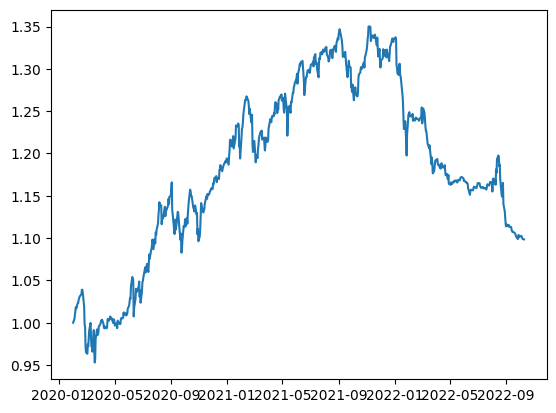

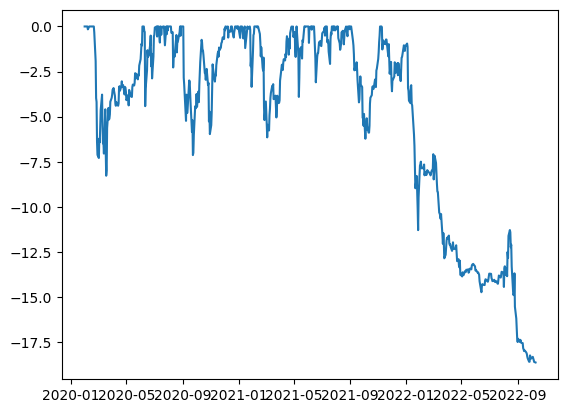

In [43]:
plt.figure()
plt.subplots()
plt.plot(cumRet)
plt.subplots()
plt.plot(-dd)